In [1]:
import  math 
import  numpy  as  np 
from  IPython.display  import  clear_output 
#from  tqdm  import  tqdm_notebook  as  tqdm
import  matplotlib  as  mpl 
import  matplotlib.pyplot  as  plt 
% matplotlib inline
import  seaborn  as  sns 
sns.color_palette ( "bright" ) 
import  matplotlib  as  mpl 
import  matplotlib.cm  as  cm

In [3]:
def run_simulation(n, r, zs):

    # centers of the n disks/wires
    unit_roots = np.array(np.exp(2j*math.pi*np.linspace(1/n,1,n)))

    # vector of radii
    rr = r*np.ones(unit_roots.shape)

    # number of terms in expansion
    N = int(max(0, round(4.0 + 0.5 * np.log10(r))))

    # number of sample points on disk/wires
    npts = 3*N + 2

    # Note on collocation: we are choosing a number npts of points on the
    # boundary of the circles of radius r, with centers at roots of unity.
    circ = np.array(np.exp(2j*math.pi*np.linspace(1/npts,1,npts)))

    # this is a list containing n arrays
    # each array has shape npts*1, i.e. they are each a column
    # vector with one row per sample point on the circles
    z_list = [(unit_roots[i] + rr[i] * circ) for i in range(n)]

    # this stacks the n arrays on top of each other, for a column vector with
    # n*npts rows.
    z = np.concatenate(z_list)

    # the constant term
    A = np.concatenate([np.zeros(1), -np.ones(z.shape[0])])
#    A = np.zeros(1)
#    A =np.append(A,-np.ones(z.shape[0])) # the constant term
#    A=A.reshape(A.shape[0],1)
    
    # right-hand side of Ax=b
    b = np.concatenate([np.zeros(1), -np.log(np.abs(z-zs))])

    for i in range(n):
        B = np.concatenate([np.ones(1), np.log(np.abs(z-unit_roots[i]))])
        # the logarithmic terms
        A = np.column_stack((A, B))
        for k in range(N):
            zck = np.power((z - unit_roots[i]), -(k+1))
            C = np.concatenate([np.zeros(1), zck.real])
            D = np.concatenate([np.zeros(1), zck.imag])
            # the algebraic terms
            A = np.column_stack((A, C, D))

    # this is an overdetermined system, fit a least-squares solution
    x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    x = np.delete(x, (0), axis=0)  # this deletes the first row

    # coeffs of the log terms, which correspond in some sense to the
    # Green's function for a singularity at the respective wires
    d = x[0:: 2 * N + 1]
    x = np.delete(x, np.s_[0::2*N+1], None)

    a = x[0::2]  # coeffs of the algebraic terms
    b = x[1::2]  # coeffs of the algebraic terms

    # Plotting
    # Note: the X and Y range here will limit what is plotted.
    X = np.linspace(-2.0*zs, 2.0*zs, 1000)
    Y = np.linspace(-2.0*zs, 2.0*zs, 1000)
    xx, yy = np.meshgrid(X, Y)

    zz = xx + 1j*yy
    uu = np.log(np.abs(zz - zs))

    for j in range(n):
        uu = uu + d[j]*np.log(np.abs(zz - unit_roots[j]))
        for k in range(N):
            zck = np.power((zz - unit_roots[j]), -(k+1))
            kk = k + j * N
            uu = uu + a[kk] * zck.real + b[kk] * zck.imag
    for j in range(n):
        uu[np.abs(zz - unit_roots[j]) <= rr[j]] = np.nan

    return xx, yy, uu

In [10]:
#Solve the problem:
n = 10; r = 0.05; # number and radius of disks
zs = 1.6
#c = np.exp(2j*np.pi*np.linspace(0,1,n)); # centers of the disks

In [11]:
xx, yy, uu = run_simulation(n, r, zs)

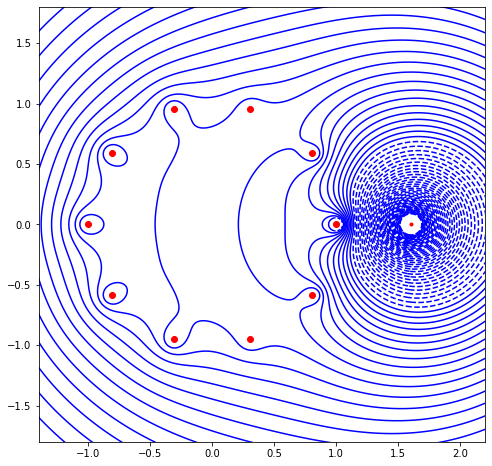

In [12]:
fig = plt.figure(figsize=(8,8))
levels = np.arange(-2, 2, 0.05)
c = np.exp(2j*np.pi*np.linspace(1/n,1,n)); # centers of the disks
plt.scatter(c.real, c.imag, color='red')
plt.contour(xx, yy, uu, levels=levels,colors='blue',corner_mask=True)
plt.plot(zs.real,zs.imag,'r.')
plt.xlim([-1.4,2.2])
plt.ylim([-1.8,1.8])
plt.savefig('cagetest.png')